# Sparklyr workshop - R Users Galicia

### 25 October 2018

## Table of Contents

- [What is sparklyr?](#What-is-sparklyr?)
- [Kickstart](#Kickstart)
- [SparkR](#SparkR)
- [Jupyter](#Jupyter)
- [Uploading the data in JSON format](#Uploading-the-data-in-JSON-format)
- [Install libraries in SparkR](#Install-libraries-in-SparkR)
- [Spark and R in Jupyter](#Spark-and-R-in-Jupyter)
    - [Configuring Spark and R](#Configuring-Spark-and-R)
    - [Loading spark context (RDDs)](#Loading-spark-context-(RDDs))
- [Reading JSON into Spark context: `jscars.json`](#Reading-JSON-into-Spark-context:-jscars.json)
    - [Basic data wrangling](#Basic-data-wrangling)
    - [Graphs](#Graphs)
    - [Models: K-means](#Models:-K-means)
- [Kill YARN application and free memory](#Kill-YARN-application-and-free-memory)
- [User Interface](#User-Interface)
- [Session](#Session)
    - [Paths recognised by sparkR](#Paths-recognised-by-sparkR)
    - [R session info](#R-session-info)
- [References](#References)

## What is sparklyr?

- Exposes Spark's API (in Scala) from R.  

- Spark lets us access to the Hadoop ecocystem.

- To put it simple, <span style="color:#fffff;font-family:monospace;"> dplyr</span> over Spark!.

- Created by Rstudio in 2016.

[How does Spark work?](https://aurora-mareviv.github.io/sparklyr_test/#/como-funciona-spark-2)


## Kickstart

Please, read the [pyspark course](https://github.com/javicacheiro/pyspark_course/blob/master/unit_1_tools.ipynb) here (points 1.1 to 1.3).

[Updated oct 2018]

Connect to one of the login nodes of the Hadoop Hortonworks Data Platform (HDP) cluster (remember to activate Forticlient VPN first!):

    MY_CESGA_USER='abcdef' # my CESGA username 
    ssh $MY_CESGA_USER@hadoop.cesga.es

In the new HDP server you have to load the Anaconda module that has the R distribution that works with Spark. 

This command needs to be executed everytime a new console is opened at CESGA:

    module load anaconda2/5.3.0  # run only once for every console
    
To see the available modules type:
    
    module available

## SparkR

### Configuring Spark and R kernel

Add this variable to .bashrc to avoid setting `Sys.setenv` in `R`.

    cd $HOME
    export R_PROFILE_USER=/usr/hdp/2.4.2.0-258/spark/R/lib/SparkR/profile/shell.R
    # reload .bashrc
    source .bashrc

### Open sparkR

Launch **sparkR** (version 3.5.1):

    sparkR

### Install libraries in sparkR

Install the libraries as needed. When you finish, exit the interactive `sparkR` session.

    > install.packages(c("sparklyr", "dplyr", "knitr", "ggplot2", "repr")
    > q()

## Jupyter

To launch a Jupyter notebook:

- Open a new console window.

- Connect to one of the login nodes of the Hadoop Hortonworks Data Platform (HDP) cluster: 

      ssh $MY_CESGA_USER@hadoop.cesga.es

- Load Anaconda2 distribution:

      module load anaconda2/5.3.0

- Launch the Jupyter notebook: 

      start_jupyter
    

- Follow the instructions in the console. You may be asked to paste an URL token into your browser. 

- Open the provided link in the browser

The notebook you have launched is tightly integrated with Spark in order to:

- Automatically opens a sparkR session with the cluster
- Dynamically expands the required executors in the cluster
- The console provides useful debugging information, showing Spark messages.

When you finish your interactive work remember to close the notebook properly:

- File -> Close and Halt


**Tip**: it is a good idea to leave two consoles open simultaneously, one for Jupyter (to open the notebook) and the other for Bash and sparkR commands.


## Uploading the data in JSON format 

First, we need to upload our data from our NFS **HOME** to the HDFS **HOME** directory.  
- You can add a single file, or an entire folder.
- You can also list or delete files, folders.

### HDFS overview and commands

See the [pyspark course](https://github.com/javicacheiro/pyspark_course/blob/master/unit_1_tools.ipynb) here (point 1.2) for HDFS basic commands.

Let's define some variables:

    # my username 
    MY_CESGA_USER='abcdef' 
    
    # my HDFS HOME 
    MY_HDFS_HOME=/user/$MY_CESGA_USER/    
    
    # my NFS HOME 
    MY_NFS_HOME=$HOME

HDFS basic commands:

    # import data into hdfs (jscars.json): 
    hdfs dfs -put $MY_NFS_HOME/Rsession/sparklyr_start/data/jscars.json  # adapt to your own path
    
    # list files 
    hdfs dfs -ls 
    # list files in a directory 
    hdfs dfs -ls $MY_HDFS_HOME
    # create a directory called 'data': 
    hdfs dfs -mkdir data 
    # delete a directory: 
    hdfs dfs -rm -r -f data
    # delete files, folders from hdfs
    hdfs dfs -rm -r -f data/jscars.json

## Spark and R in Jupyter

Set `R` environment variables (needed for Jupyter notebooks in the cluster `sparkR` installation).

In [1]:
# Sys.setenv(SPARK_HOME='/usr/hdp/2.4.2.0-258/spark/R/lib/SparkR/profile/shell.R') 
  # commented after being added to .bashrc
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

Load libraries:

In [2]:
options(warn = -1) # disable warnings

In [16]:
x <- c("sparklyr", "dplyr", "knitr", "ggplot2", "repr")
lapply(x, require, character.only = TRUE, quietly = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

### Loading spark context (RDDs)

Currently there are three types of contexts:

- Local context: 
    - Interactive. 
    - If the user exits session, the tasks are terminated (use `screen` to run after session close).
    - All processes reside in the LOGIN node (both drivers and executors).
    - Can only be used for tasks that require very few resources.
- YARN-client: 
    - Interactive.
    - If the user exits session, the tasks are terminated (use `screen` to run after session close).
    - The driver resides in the LOGIN node, but the executors are in the CLUSTER nodes. Thus, executors can use all the memory available for the task in the CLUSTER nodes.
    - Can be used for memory-intensive tasks.
- YARN-cluster:
    - Not interactive.
    - Both the driver and the executors reside in the CLUSTER nodes.
    - Can be used for memory-intensive tasks.
    - Currenty doesn't seem available for this version of `R/sparklyr`.
    
Defining a new context (`sc`) overwrites the previous one.

In [4]:
SPARK_HOME = Sys.getenv('SPARK_HOME')

In [5]:
# Initiating spark context: local (for 'low memory' tasks only!)
# sc <- spark_connect(master = "local", spark_home = SPARK_HOME)

# Initiating spark context: yarn (for loading bigger datasets)
sc <- spark_connect(master = "yarn-client", spark_home = SPARK_HOME)

## Reading JSON into Spark context: `jscars.json`

The data `jscars.json` is the `mtcars` dataset saved in a JSON format.

Beware: the command `getwd()` gives us our NFS working directory, not an HDFS directory.

In [6]:
wdir <- getwd() # NFS working directory, not HDFS!

To import files, we must refer to the path in the HDFS directory tree (see `$ hdfs dfs -ls`):

In [7]:
jscars <- spark_read_json(sc, name = "jscars", path = "jscars.json") # HDFS working directory

In [8]:
jscars %>%
  head(6) %>%
  collect()

am,carb,cyl,disp,drat,gear,hp,mpg,qsec,vs,wt
1,4,6,160,3.90,4,110,21.0,16.46,0,2.620
1,4,6,160,3.90,4,110,21.0,17.02,0,2.875
1,1,4,108,3.85,4,93,22.8,18.61,1,2.320
0,1,6,258,3.08,3,110,21.4,19.44,1,3.215
0,2,8,360,3.15,3,175,18.7,17.02,0,3.440
0,1,6,225,2.76,3,105,18.1,20.22,1,3.460


### Basic data wrangling

We can make good use of `magrittr::%>%` *pipes* for data wrangling or window operations:  
The `warnings` issued here are usually not important. They depend on the `sparklyr` version. See [here](https://github.com/rstudio/sparklyr/issues/426) for more info.

In [9]:
jscars %>%
  group_by(vs) %>%
  filter(gear == 3, hp > 100) %>%
  mutate(horsepower_by_gear = rank(desc(hp / gear))) %>%
  mutate(mpg_rank = rank(mpg)) %>%
  select(gear, mpg_rank, horsepower_by_gear) %>% 
  head(6) %>%
  collect()

vs,gear,mpg_rank,horsepower_by_gear
0,3,1,4
0,3,1,5
0,3,3,1
0,3,4,1
0,3,5,3
0,3,6,6


### Graphs 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


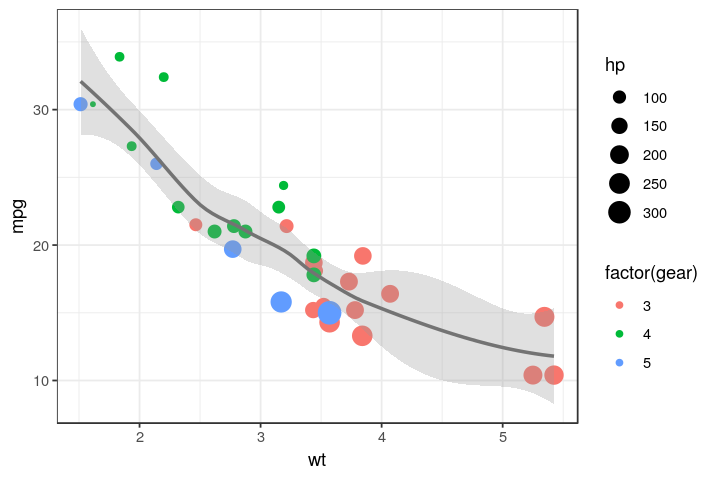

In [10]:
options(repr.plot.width=6, repr.plot.height=4) #repr library

jscars %>%
  collect() %>%
    ggplot(aes(wt, mpg)) +
    geom_point(aes(colour=factor(gear), size=hp)) + 
    geom_smooth(colour="#737373", alpha=0.3) + 
    theme_bw()

### Models: K-means 

In [11]:
kmeans_model <- jscars %>%
  select(wt, mpg) %>%
  ml_kmeans(y ~ wt + mpg, k = 3)

print(kmeans_model)
# kmeans_model %>% str()

K-means clustering with 3 clusters

Cluster centers:
        wt      mpg
1 4,058667 14,45833
2 1,873000 30,06667
3 3,072143 20,64286

Within Set Sum of Squared Errors =  154,0229

In [20]:
# predict the associated class
predicts <- sdf_predict(jscars, kmeans_model) 
predicted <- collect(predicts)
collect(head(predicted))
base::table(predicted$am, predicted$prediction)

am,carb,cyl,disp,drat,gear,hp,mpg,qsec,vs,wt,features,prediction
1,4,6,160,"3,90",4,110,"21,0","16,46",0,"2,620","2,62, 21,00",2
1,4,6,160,"3,90",4,110,"21,0","17,02",0,"2,875","2,875, 21,000",2
1,1,4,108,"3,85",4,93,"22,8","18,61",1,"2,320","2,32, 22,80",2
0,1,6,258,"3,08",3,110,"21,4","19,44",1,"3,215","3,215, 21,400",2
0,2,8,360,"3,15",3,175,"18,7","17,02",0,"3,440","3,44, 18,70",2
0,1,6,225,"2,76",3,105,"18,1","20,22",1,"3,460","3,46, 18,10",2


   
     0  1  2
  0 10  0  9
  1  2  6  5

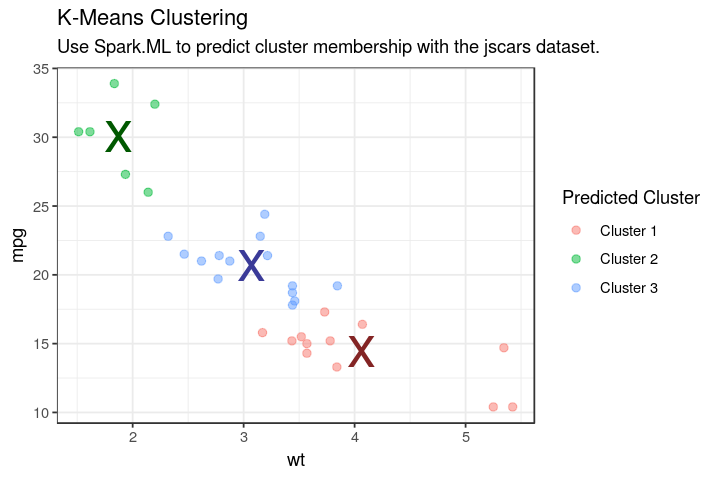

In [21]:
# plot cluster membership
sdf_predict(kmeans_model) %>%
  collect() %>%
  ggplot(aes(wt, mpg)) +
    geom_point(aes(wt, mpg, col = factor(prediction + 1)),
               size = 2, alpha = 0.5) + 
    geom_point(data = kmeans_model$centers, aes(wt, mpg),
               col = scales::muted(c("red", "green", "blue")),
               pch = 'x', size = 12) +
    scale_color_discrete(name = "Predicted Cluster",
                         labels = paste("Cluster", 1:3)) +
    labs(
      x = "wt",
      y = "mpg",
      title = "K-Means Clustering",
      subtitle = "Use Spark.ML to predict cluster membership with the jscars dataset."
    ) +
    theme_bw()

## Kill YARN application and free memory

How to see the aggregated logs produced by a job:
      
    yarn logs -applicationId <applicationID> | less

How to see the list of running jobs:
    
    yarn application -list

Kill an application:
    
    yarn application -kill <applicationID>
    
For further information check [The YARN Tutorial](http://bigdata.cesga.es/tutorials/yarn.html#/)

## User Interface

Login to have access to the Spark UI

[https://bigdata.cesga.es/web-ui/app](https://bigdata.cesga.es/web-ui/app/#/login)

## Session 

### Paths recognised by sparkR 

In [18]:
.libPaths()
Sys.getenv("R_HOME")

### R session info

In [19]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS: /opt/cesga/anaconda/Anaconda2-5.3.0/lib/R/lib/libRblas.so
LAPACK: /opt/cesga/anaconda/Anaconda2-5.3.0/lib/R/lib/libRlapack.so

locale:
[1] es_ES.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] bindrcpp_0.2.2       repr_0.15.0          ggplot2_3.0.0       
[4] knitr_1.20           dplyr_0.7.6          sparklyr_0.8.4      
[7] SparkR_1.6.1         RevoUtils_11.0.1     RevoUtilsMath_11.0.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.4 purrr_0.2.5      lattice_0.20-35 
 [5] colorspace_1.3-2 htmltools_0.3.6  yaml_2.2.0       base64enc_0.1-3 
 [9] rlang_0.2.1      later_0.7.3      pillar_1.3.0     withr_2.1.2     
[13] glue_1.3.0       DBI_1.0.0        dbplyr_1.2.2     uuid_0.1-2      
[17] bindr_0.1.1      plyr_1.8.4       stringr_1.3

## References 

- [`sparklyr` presentation R Users Galicia](https://aurora-mareviv.github.io/sparklyr_test)
- [`sparklyr` presentation](https://cdn.oreillystatic.com/en/assets/1/event/193/Sparklyr_%20An%20R%20interface%20for%20Apache%20Spark%20Presentation.pdf)
- [`sparklyr` tutorial](http://spark.rstudio.com/).
- [`sparklyr` cheatsheet](http://spark.rstudio.com/images/sparklyr-cheatsheet.pdf).
- [`sparklyr`: creating extensions](http://spark.rstudio.com/extensions.html).
- [Differences between `sparkr` and `sparklyr`](https://stackoverflow.com/questions/39494484/sparkr-vs-sparklyr).
- [Hive Operators and UDFs](https://cwiki.apache.org/confluence/display/Hive/LanguageManual+UDF).
- [String Functions in Hive](http://www.folkstalk.com/2011/11/string-functions-in-hive.html).
- [POSIX regular expressions](https://www.postgresql.org/docs/9.4/static/functions-matching.html#FUNCTIONS-POSIX-REGEXP).
- [Material for Machine Learning Workshop Galicia 2016](http://nbviewer.jupyter.org/github/javicacheiro/machine_learning_galicia_2016/blob/master/notebooks/sentiment_analysis-amazon_books.ipynb).
- [PySpark Course](https://github.com/javicacheiro/pyspark_course).
- [PySpark Programming Guide](https://spark.apache.org/docs/0.9.0/python-programming-guide.html).
- [PySpark cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf).
- [Jupyter shortcuts](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)

Author: A. Baluja